In [2]:
#Imports
import pandas as pd
import numpy as np
from goatools.base import get_godag
from goatools.anno.gaf_reader import GafReader
from goatools.gosubdag.gosubdag import GoSubDag
from collections import defaultdict

In [3]:
#Get the GO terms
godag = get_godag("go-basic.obo", optional_attrs='relationship')

  EXISTS: go-basic.obo
go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms; optional_attrs(relationship)


In [4]:
#Get the GO Annotation File
gogaf = GafReader("goa_yeast.gaf")

HMS:0:00:05.577741  91,452 annotations READ: goa_yeast.gaf 


In [5]:
#Build pairs and sl columns in gene2sl
genes     = pd.read_csv('gsets_1', header=None, names=["genes"])
sl_lables = pd.read_csv('sl_1', header=None, names=["sl"])
gene2sl   = pd.concat([genes, sl_lables], axis=1)
#gene2sl   = gene2sl.set_index('genes')

In [6]:
#Now get a gene to GO id dict.
gene2goid = defaultdict(set)
for assoc in gogaf.associations:
    for syn in assoc.DB_Synonym:
        gene2goid[syn].add(assoc.GO_ID)

In [7]:
#Now build the hierarchy, meaning each node is represented by the no. of all its descendants
genes2terms = pd.DataFrame()
gene2terms = {}
for index, row in gene2sl.iterrows():
    for gene in row['genes'].split("$"):
        #No such gene, build it
        if gene not in gene2terms:
            go_ids = gene2goid.get(gene)
            if go_ids is None:
                print("Could not find the gene {} in GAF".format(gene))               
            else:
                gene2terms[gene] = {}
                for go_id in go_ids:
                    term = godag.get(go_id)
                    if term.namespace == 'biological_process':
                        # Create a subset of the GO DAG which contains:
                        # The selected GO term and the 'is_a' GO terms above it, by setting relationships=False
                        gosubdag = GoSubDag(go_id, godag, relationships=False, prt=False) 
                        ancestors = defaultdict(set)
                        if go_id in gosubdag.rcntobj.go2parents:
                            for p_go in gosubdag.rcntobj.go2parents[go_id]:
                                dict_anc = gosubdag.go2nt[p_go]._asdict()
                                ancestors[dict_anc['depth']].add(dict_anc['GO'])
                        #Get the leaf GO term
                        if go_id not in gene2terms[gene]:
                            gene2terms[gene][go_id] = 1
                        else:
                            gene2terms[gene][go_id] += 1
                        #Sum up all the ancestors values
                        count_genes = 1  
                        for level in range(len(ancestors) - 1, -1, -1):
                            for GO in ancestors[level]:
                                if GO not in gene2terms[gene]:
                                    gene2terms[gene][GO] = count_genes
                                else:
                                    gene2terms[gene][GO] += count_genes                                
                            count_genes += len(ancestors[level])  
                        
    #Build the combination of the 2 genes
    g1, g2 = row['genes'].split("$")
    gene1 = gene2terms[g1]
    gene2 = gene2terms[g2]         
    genesdict = {key: gene1.get(key, 0) + gene2.get(key, 0)
                 for key in set(gene1) | set(gene2)}
    genesdict['genes'] = row['genes']
    genesdict['sl'] = row['sl']
    #Add the final line and clean NaN
    genes2terms = genes2terms.append(genesdict, ignore_index=True)
    genes2terms = genes2terms.fillna(0)

In [135]:
genes2terms.to_pickle("genes2terms.pkl")

In [17]:
#len(pairs_terms.columns) , optional_attrs='relationship'

30931

In [16]:

#gene_pairs.describe()
#pairs_terms = pd.concat([gene_pairs, sl_lables, pairs_terms], axis=1)
#pairs_terms.head(15)

,sl
count,134275.000000
mean,0.074198
std,0.262095
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [10]:
# # remove column without no information
# nunique = pairs_terms.apply(pd.Series.nunique)
# cols_to_drop = nunique[nunique == 1].index
# print("dropping {} columns".format(len(cols_to_drop)))
# pairs_terms.drop(cols_to_drop, axis=1)

In [2]:
# pairs_terms.to_pickle("pairs_terms.pkl")
pairs_terms = pd.read_pickle("pairs_terms.pkl")

In [3]:
X = pairs_terms.loc[:, pairs_terms.columns != 'sl']
Y = pairs_terms['sl']

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [5]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='lbfgs')

In [6]:
model.fit(X, Y)

/usr/local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [31]:
standard_model = pd.read_csv('all.onto_genes.features.cv_all.rf.predictions')
standard_model = standard_model.rename(columns={"0": "prob"})
standard_model['sl'] = -1
standard_model.loc[standard_model['prob'] >= 0.5,'sl'] = 1
standard_model.loc[standard_model['prob'] < 0.5,'sl'] = 0
standard_model['pairs'] = pairs_terms.index.values
standard_model = standard_model.set_index('pairs')

In [7]:
# standard_model.to_pickle("standard_model.pkl")
standard_model = pd.read_pickle("standard_model.pkl")

In [8]:
y_pred = model.predict(X)
from sklearn.metrics import accuracy_score
accuracy_score(Y, standard_model['sl'])

0.9552258814066759

In [9]:
accuracy_score(Y, y_pred)

0.9426471245363958

In [10]:
from sklearn.metrics import classification_report
target_names = ['non sl', 'sl']
print("theirs:")
print(classification_report(Y, standard_model['sl'], target_names=target_names))

theirs:
              precision    recall  f1-score   support

      non sl       0.96      0.99      0.98    124311
          sl       0.81      0.51      0.63      9963

   micro avg       0.96      0.96      0.96    134274
   macro avg       0.89      0.75      0.80    134274
weighted avg       0.95      0.96      0.95    134274



In [11]:
print("ours:")
print(classification_report(Y, y_pred, target_names=target_names))

ours:
              precision    recall  f1-score   support

      non sl       0.94      1.00      0.97    124311
          sl       0.88      0.26      0.41      9963

   micro avg       0.94      0.94      0.94    134274
   macro avg       0.91      0.63      0.69    134274
weighted avg       0.94      0.94      0.93    134274



Baseline: ROC AUC=0.500
Logistic: ROC AUC=0.872
Standard: ROC AUC=0.918


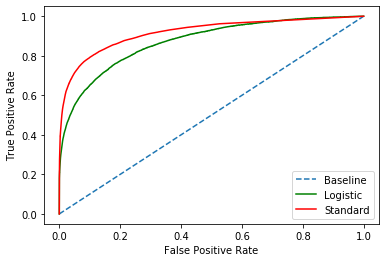

In [14]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(Y))]
# predict probabilities
lr_probs = model.predict_proba(X)
# # keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(Y, ns_probs)
lr_auc = roc_auc_score(Y, lr_probs)
standard_auc = roc_auc_score(Y, standard_model['prob'])
# summarize scores
print('Baseline: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
print('Standard: ROC AUC=%.3f' % (standard_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(Y, lr_probs)
base_fpr, base_tpr, _ = roc_curve(Y, standard_model['prob'])
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='Baseline')
pyplot.plot(lr_fpr, lr_tpr, label='Logistic', color='green')
pyplot.plot(base_fpr, base_tpr, label='Standard', color='red')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [38]:
###################################################  DRAFTS ##########################################################
df = pd.DataFrame(columns=['lib', 'qty1', 'qty2', 'qty3', 'qty4'])
df2 = pd.DataFrame(columns=['lib', 'qty1', 'qty2'])
for i in range(5):
    df2.loc[i] = ['name' + str(i)] + list(randint(10, size=2))
df3 = pd.DataFrame(columns=['lib', 'qty1', 'qty2'])
for i in range(5):
    df3.loc[i] = ['name' + str(i)] + list(randint(10, size=2))
df.loc[0] = df2[df2.lib == 'name0'] + df3[df3.lib == 'name0'] 
df
df2
df3

ValueError: cannot set a row with mismatched columns

In [35]:
import pandas as pd
import numpy as np

df = pd.DataFrame([{'c1':10, 'c2':100}, {'c1':11,'c2':110}, {'c1':12,'c2':120}])
for index, row in df.iterrows():
    print(str(index) + '\n')
    print(row['c1'], row['c2'])

0

10 100
1

11 110
2

12 120


In [76]:
# List of Tuples
students = [ ('jack', 34, 'Sydeny' , 'Australia') ,
             ('Riti', 30, 'Delhi' , 'India' ) ,
             ('Vikas', 31, 'Mumbai' , 'India' ) ,
             ('Neelu', 32, 'Bangalore' , 'India' ) ,
             ('John', 16, 'New York' , 'US') ,
             ('Mike', 17, 'las vegas' , 'US')  ]
#print('{NS} {GO} D{depth:02} {GO_name}'.format(**gosubdag.go2nt[p_go]._asdict()))
#Create a DataFrame object
dfObj = pd.DataFrame(students, columns = ['Name' , 'Age', 'City' , 'Country'], index=['a', 'b', 'c' , 'd' , 'e' , 'f'])
# Pass the row elements as key value pairs to append() function 
dfObj = dfObj.append({'Name' : 'Sahil' , 'City' : 'my butt'} , ignore_index=True)
dfObj = 

True

In [92]:
testdf = pd.DataFrame()
testdf = testdf.append({'a': 1, 'b': 2}, ignore_index=True)
testdf = testdf.append({'c': 1, 'e': 2}, ignore_index=True)
testdf

,a,b,c,e
0,1.0,2.0,NaN,NaN
1,NaN,NaN,1.0,2.0


In [96]:
ty = defaultdict(set)
ty['YW2'] = {'go0001':1, 'go0002':3}
'YW2' not in ty

False

In [98]:
dict1 = {'a': 5, 'b': 7}
dict2 = {'a': 3, 'c': 1}

result = {key: dict1.get(key, 0) + dict2.get(key, 0)
          for key in set(dict1) | set(dict2)}
result['genes'] = 'YSYD$YSHS2'
result['sl'] = 0
ff = pd.DataFrame()
ff = ff.append(result, ignore_index=True)
ff = ff.append({}, ignore_index=True)
ff = ff.fillna(0)
ff

,a,b,c,genes,sl
0,8.0,7.0,1.0,YSYD$YSHS2,0.0
1,0.0,0.0,0.0,0,0.0


In [100]:
g1, g2 = 'sdsd$uuuu'.split('$')
print(g1)
print(g2)

sdsd
uuuu


In [103]:
thisset = {"apple", "banana", "cherry"}
len(thisset)

3

In [ ]:
#Now build the biological process GO terms columns
#genes2terms = pd.DataFrame()
#genes2terms['genes'] = '0'
#genes2terms['sl'] = 0
#for go_id in godag:
#    go_id_term = godag.get(go_id)
#    if go_id_term.namespace == 'biological_process':
#        genes2terms[go_id] = 0
#We'll keep each gene its calc. of descendants        
#gene2terms = genes2terms.copy()  
#gene2terms = gene2terms.drop(['sl'], axis=1)

In [112]:
yy = defaultdict(set)
yy['d'].add({'fdsf': 1})
yy

TypeError: unhashable type: 'dict'

In [131]:
gg = {}
gg['zin'] = {'kk':1}
gg['zin']['kk'] += 1
gg['zin']['tt'] += 1
gg

KeyError: 'tt'